# Poboljšanje rezultata

## Učitavanje biblioteka

In [271]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

## Početni

Novi izračun se može postići kombiniranjem tri ključne vrijednosti iz skani rezultata, uključujući prosječni identitet nukleotida (ANI), udio usklađenosti referentnog genoma (Align_fraction_ref) i udio usklađenosti upita (Align_fraction_query), kako bi se dobio sveobuhvatan pogled na sličnost između analiziranih genoma.

Prvi korak u analizi uključivao je stvaranje baze podataka referentnih genoma korištenjem naredbe skani sketch. Putanja do referenci zapisana je u datoteci gtdb_file_names.txt, a rezultati su pohranjeni u direktoriju gtdb_skani_database_ani.
*  skani sketch -l gtdb_file_names.txt -o gtdb_skani_database_ani -t 20

Nakon uspješnog stvaranja baze podataka, provedena je analiza sekvenci uzoraka readova pomoću naredbe skani search. Uzorak readova, definiran u datoteci random_sample.fasta, uspoređen je s prethodno stvorenim referentnim genomima koji su pohranjeni u bazi podataka gtdb_skani_database_ani. Rezultati ove usporedbe evidentirani su u datoteci skani_results_file.tsv.
*  skani search --qi random_sample.fasta -d gtdb_skani_database_ani/ -o skani_results_file.tsv -t 25

Korištena je opcija -t (zastavica threads) kako bi se ubrzao proces koristeći više jezgrenih niti.

In [272]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import pandas as pd

In [273]:
putanja_do_skani_datoteke = 'skani_results_file.tsv'
df = pd.read_csv(putanja_do_skani_datoteke, sep='\t')

In [274]:
odabrani_stupci = ['Query_file','ANI','Align_fraction_ref','Align_fraction_query','Ref_name','Query_name']
df_odabrani = df[odabrani_stupci]
tablica = list(df_odabrani.iloc)
dictionary = {}
rjecnik = {}
suma = 0
for i in tablica:
  ref_name = i[3].split('|')[0]
  ref_taxid = i[3].split('speciesID|')[-1].split('|')[0]
  query_id = i[4].split(',')[0].split(' ')[0]
  query_name = i[4].split(',')[0].split(' ')[-1]
  query_speciesid = i[5].split('|')[3]
  ani_score = i[0]
  af_ref = i[1]
  af_query = i[2]
  if (ref_name, ref_taxid) in dictionary:
    ubaci = [ani_score, af_ref, af_query, query_speciesid, query_name, query_id]
    dictionary[(ref_name, ref_taxid)].append(ubaci)
  else:
    ubaci = [ani_score, af_ref, af_query, query_speciesid, query_name, query_id]
    dictionary[(ref_name, ref_taxid)] = [ubaci]
  if (query_id, query_name, query_speciesid) in rjecnik:
    ubaci = [ani_score, af_ref, af_query, ref_name, ref_taxid]
    rjecnik[(query_id, query_name, query_speciesid)].append(ubaci)
  else:
    ubaci = [ani_score, af_ref, af_query, ref_name, ref_taxid]
    rjecnik[(query_id, query_name, query_speciesid)] = [ubaci]
for k,v in rjecnik.items():
  rjecnik[k] = sorted(v, key=lambda x: (x[2], x[0], x[1]), reverse=True)[0]
for k,v in dictionary.items():
  dictionary[k] = sorted(v, key=lambda x: (x[2], x[0], x[1]), reverse=True)[0]
for j in rjecnik.keys():
  if j[-1] == rjecnik[j][-1]:
    suma += 1
print(f'TP: {suma}')
print(f'FP: {len(list(rjecnik.items()))-suma}')
print(f'FP: {10000-len(list(rjecnik.items()))}')
print(f'TN: 0')

TP: 3287
FP: 60
FP: 6653
TN: 0


In [275]:
print(f'Za {2187-len(list(dictionary.items()))} organizama nije ništa klasificirano.')

Za 58 organizama nije ništa klasificirano.


Preciznost: 0.9821
Odziv: 0.3307
F1-mjera: 0.4948
Točnost: 0.3287
ROC AUC: 0.4970


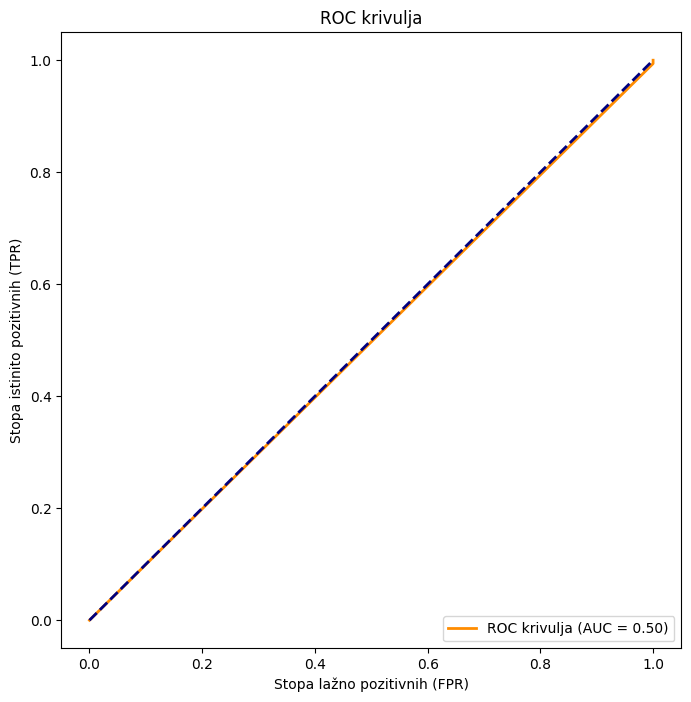

In [276]:
TP = 3287
FP = 60
FN = 6653
TN = 0

precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1 = 2 * (precision * recall) / (precision + recall)
accuracy = (TP + TN) / (TP + FP + FN + TN)

total_positive = TP + FN
total_negative = FP + TN

print(f'Preciznost: {precision:.4f}')
print(f'Odziv: {recall:.4f}')
print(f'F1-mjera: {f1:.4f}')
print(f'Točnost: {accuracy:.4f}')

fpr, tpr, thresholds = roc_curve([1] * total_positive + [0] * total_negative, [1] * TP + [0] * FP + [1] * FN + [0] * TN)
roc_auc = auc(fpr, tpr)
print(f'ROC AUC: {roc_auc:.4f}')

plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC krivulja (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('Stopa lažno pozitivnih (FPR)')
plt.ylabel('Stopa istinito pozitivnih (TPR)')
plt.title('ROC krivulja')
plt.legend(loc='lower right')
plt.show()

## Prvi pristup

Započela sam poboljšanja analize korištenjem alata Skani implementirajući određene optimizacije i prilagodbe parametara. Prvo sam koristila naredbu skani sketch s opcijama -l gtdb_file_names.txt --medium -m 250 -o gtdb_popravljanje_1 -t 20. Ključna prilagodba ovdje bila je postavljanje veličine markera (-m) na 250, što je rezultat prosječne duljine očitanja (u mojem slučaju ona iznosi 5000 nukleotida) podijeljene s 20, kako bih osigurala barem 20 markera u prosjeku. Također, smanjila sam parametar c sa standardnih 125 na 70, što se postiže opcijom --medium. Ova prilagodba doprinosi poboljšanju preciznosti izračuna sličnosti genoma.

Nakon toga, koristila sam naredbu skani search s opcijama --qi random_sample.fasta -d gtdb_popravljanje_1/ --no-marker-index --keep-refs -s 92 -o skani_baza1_v3.tsv -t 25. U nastojanju da poboljšam učinkovitost i ubrzam analizu, provela sam par promjena u postavkama alata skani. Prva značajna promjena bila je isključivanje indeksiranja markera, označeno opcijom --no-marker-index. Dodatno, uključivanje opcije --keep-refs, koja zadržava referentne genome u memoriji, pokazalo se korisnim za ubrzanje procesa pretrage, posebno u situacijama kada se uspoređuju brojni slični sekvencijalni upiti. Pored toga, postavila sam prag za aproksimativni ANI cutoff, odnosno --s 92. Ova prilagodba znači da će se izračuni izvršavati samo ako je predloženi ANI (dobiven pomoću k-mer maksimalnog indeksa sadržaja) veći od 92%.








In [277]:
putanja_do_skani_datoteke = 'skani_baza1_v3.tsv'
df = pd.read_csv(putanja_do_skani_datoteke, sep='\t')
odabrani_stupci = ['Query_file','ANI','Align_fraction_ref','Align_fraction_query','Ref_name','Query_name']
df_odabrani = df[odabrani_stupci]
tablica = list(df_odabrani.iloc)
a = {}
b = {}
for i in tablica:
  ref_name = i[3].split('|')[0]
  ref_taxid = i[3].split('speciesID|')[-1].split('|')[0]
  query_id = i[4].split(',')[0].split(' ')[0]
  query_name = i[4].split(',')[0].split(' ')[-1]
  query_speciesid = i[5].split('|')[3]
  ani_score = i[0]
  af_ref = i[1]
  af_query = i[2]
  if (ref_name, ref_taxid) in a:
    ubaci = [ani_score, af_ref, af_query, query_speciesid, query_name, query_id]
    a[(ref_name, ref_taxid)].append(ubaci)
  else:
    ubaci = [ani_score, af_ref, af_query, query_speciesid, query_name, query_id]
    a[(ref_name, ref_taxid)] = [ubaci]
  if (query_id, query_name, query_speciesid) in b:
    ubaci = [ani_score, af_ref, af_query, ref_name, ref_taxid]
    b[(query_id, query_name, query_speciesid)].append(ubaci)
  else:
    ubaci = [ani_score, af_ref, af_query, ref_name, ref_taxid]
    b[(query_id, query_name, query_speciesid)] = [ubaci]
c = 0
for k,v in a.items():
  a[k] = sorted(v, key=lambda x: (x[2], x[0], x[1]), reverse=True)[0]
for k,v in b.items():
  b[k] = sorted(v, key=lambda x: (x[2], x[0], x[1]), reverse=True)[0]
for j in b.keys():
  if j[-1] == b[j][-1]:
    c += 1
print(f'TP: {c}')
print(f'FP: {len(list(b.items()))-c}')
print(f'FP: {10000-len(list(b.items()))}')
print(f'TN: 0')

TP: 6224
FP: 158
FP: 3618
TN: 0


In [278]:
print(f'Za samo {2187-len(list(a.items()))} organizam nije ništa klasificirano.')

Za samo 1 organizam nije ništa klasificirano.


Preciznost: 0.9752
Odziv: 0.6324
F1-mjera: 0.7673
Točnost: 0.6224
ROC AUC: 0.4920


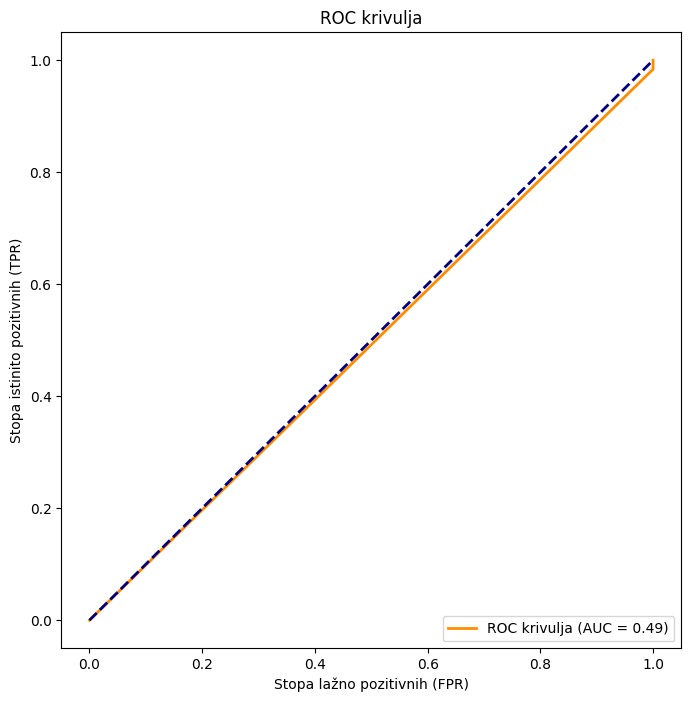

In [279]:
TP = 6224
FP = 158
FN = 3618
TN = 0

precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1 = 2 * (precision * recall) / (precision + recall)
accuracy = (TP + TN) / (TP + FP + FN + TN)

total_positive = TP + FN
total_negative = FP + TN

print(f'Preciznost: {precision:.4f}')
print(f'Odziv: {recall:.4f}')
print(f'F1-mjera: {f1:.4f}')
print(f'Točnost: {accuracy:.4f}')

fpr, tpr, thresholds = roc_curve([1] * total_positive + [0] * total_negative, [1] * TP + [0] * FP + [1] * FN + [0] * TN)
roc_auc = auc(fpr, tpr)
print(f'ROC AUC: {roc_auc:.4f}')

plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC krivulja (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('Stopa lažno pozitivnih (FPR)')
plt.ylabel('Stopa istinito pozitivnih (TPR)')
plt.title('ROC krivulja')
plt.legend(loc='lower right')
plt.show()

## Drugi pristup

U drugom dijelu optimizacije analize, dodatno sam prilagodila postavke alata Skani kako bih postigla još preciznije rezultate. Naredbama skani sketch -l gtdb_file_names.txt --slow -m 250 -o gtdb_popravljanje_2 -t 20 i skani search --qi random_sample.fasta -d gtdb_popravljanje_2/ --no-marker-index --keep-refs -s 92 -o skani_baza2_v2.tsv -t 25, posebno sam naglasila važnost preciznosti nad brzinom izvođenja.

Konkretno, značajno sam smanjila parametar c (za više od 50%), postavivši ga na 30 upotrijebivši zastavicu --slow, čime sam postigla dublje i temeljitije usporedbe genoma. Ova prilagodba omogućuje alatu Skani da bude manje tolerantan prema manje sličnim sekvencama, ističući različitosti koje bi inače mogle proći nezamijećeno pri većem c. Ovo poboljšanje ima za cilj maksimiziranje numeričkih vrijednosti ANI, Align_fraction_ref i Align_fraction_query.

In [280]:
putanja_do_skani_datoteke = 'skani_baza2_v2.tsv'
df = pd.read_csv(putanja_do_skani_datoteke, sep='\t')
odabrani_stupci = ['Query_file','ANI','Align_fraction_ref','Align_fraction_query','Ref_name','Query_name']
df_odabrani = df[odabrani_stupci]
tablica = list(df_odabrani.iloc)
e = {}
f = {}
for i in tablica:
  ref_name = i[3].split('|')[0]
  ref_taxid = i[3].split('speciesID|')[-1].split('|')[0]
  query_id = i[4].split(',')[0].split(' ')[0]
  query_name = i[4].split(',')[0].split(' ')[-1]
  query_speciesid = i[5].split('|')[3]
  ani_score = i[0]
  af_ref = i[1]
  af_query = i[2]
  if (ref_name, ref_taxid) in e:
    ubaci = [ani_score, af_ref, af_query, query_speciesid, query_name, query_id]
    e[(ref_name, ref_taxid)].append(ubaci)
  else:
    ubaci = [ani_score, af_ref, af_query, query_speciesid, query_name, query_id]
    e[(ref_name, ref_taxid)] = [ubaci]
  if (query_id, query_name, query_speciesid) in f:
    ubaci = [ani_score, af_ref, af_query, ref_name, ref_taxid]
    f[(query_id, query_name, query_speciesid)].append(ubaci)
  else:
    ubaci = [ani_score, af_ref, af_query, ref_name, ref_taxid]
    f[(query_id, query_name, query_speciesid)] = [ubaci]
d = 0
for k,v in e.items():
  e[k] = sorted(v, key=lambda x: (x[2], x[0], x[1]), reverse=True)[0]
for k,v in f.items():
  f[k] = sorted(v, key=lambda x: (x[2], x[0], x[1]), reverse=True)[0]
for j in f.keys():
  if j[-1] == f[j][-1]:
    d += 1
print(f'TP: {d}')
print(f'FP: {len(list(f.items()))-d}')
print(f'FP: {10000-len(list(f.items()))}')
print(f'TN: 0')

TP: 6307
FP: 158
FP: 3535
TN: 0


In [281]:
print(f'Za samo {2187-len(list(e.items()))} organizam nije ništa klasificirano.')

Za samo 1 organizam nije ništa klasificirano.


Preciznost: 0.9756
Odziv: 0.6408
F1-mjera: 0.7735
Točnost: 0.6307
ROC AUC: 0.4920


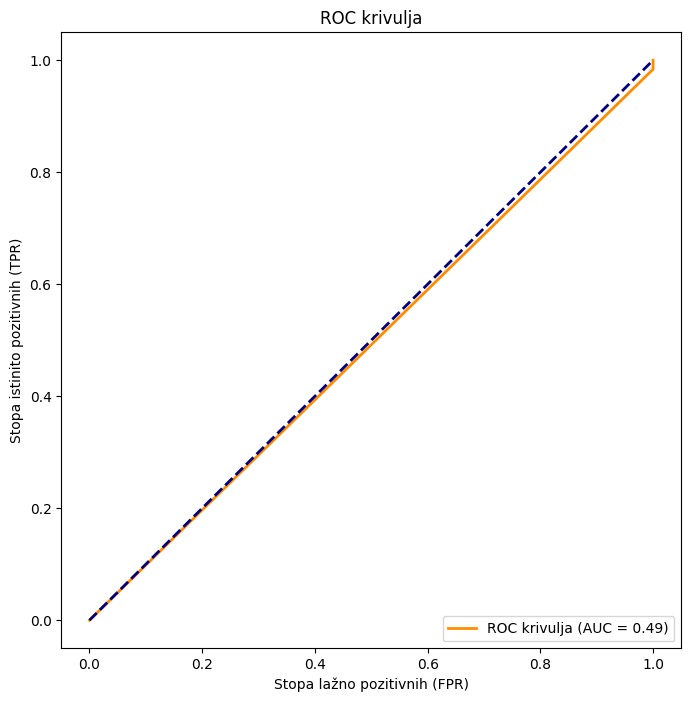

In [282]:
TP = 6307
FP = 158
FN = 3535
TN = 0

precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1 = 2 * (precision * recall) / (precision + recall)
accuracy = (TP + TN) / (TP + FP + FN + TN)

total_positive = TP + FN
total_negative = FP + TN

print(f'Preciznost: {precision:.4f}')
print(f'Odziv: {recall:.4f}')
print(f'F1-mjera: {f1:.4f}')
print(f'Točnost: {accuracy:.4f}')

fpr, tpr, thresholds = roc_curve([1] * total_positive + [0] * total_negative, [1] * TP + [0] * FP + [1] * FN + [0] * TN)
roc_auc = auc(fpr, tpr)
print(f'ROC AUC: {roc_auc:.4f}')

plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC krivulja (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('Stopa lažno pozitivnih (FPR)')
plt.ylabel('Stopa istinito pozitivnih (TPR)')
plt.title('ROC krivulja')
plt.legend(loc='lower right')
plt.show()

## Zaključak

Uvođenjem prilagodbi i optimizacija u analizu genoma pomoću alata Skani, ostvareni su značajni napretci u kvaliteti klasifikacije. Početno stanje obuhvaćalo je samo 3347 klasificiranih readova od ukupno 10000, pri čemu smo imali 3287 True Positives (TP), 60 False Positives (FP) i 6653 False Negatives (FN). Niti jedan read nije bio prisutan u uzorku za 58 određenih strainova, ukazujući na izazove u detekciji tih specifičnih genoma.

Prvim pristupom optimizacije, broj klasificiranih readova gotovo se udvostručio, dosegnuvši broj od 6382. Detaljnija analiza rezultirala je s 6224 TP i 158 FP, dok je 3618 readova ostalo False Negative (FN).

Drugi pristup optimizacije rezultirao je s daljnjim poboljšanjem, postižući 6307 TP, 158 FP i 3535 FN. Važno je naglasiti da su netočno klasificirani readovi zadržani na istom broju, što sugerira konzistentnost u smanjenju broja FN.

Osim toga, istaknuto je smanjenje broja organizama za koje nije bilo ništa klasificirano na samo jedan, što ukazuje na preciznije definiranje genoma u uzorcima. Ova poboljšanja odnose se na oba pristupa.

Na kraju, oba pristupa rezultiraju značajnim poboljšanjima u kvaliteti klasifikacije genoma, pridonoseći napretku u bioinformatičkim analizama i otvarajući mogućnosti za daljnja istraživanja u području.

In [283]:
print('Par primjera ispisa rezultata za oba pristupa u odnosu na početne:\n')
for rang in range(25):
  key, value = list(rjecnik.items())[rang]
  print(f'Read: {key}')
  print(f'Početni rezultati klasifikacije: {value}')
  print(f'Prvi pristup: {b[key]}')
  print(f'Drugi pristup: {f[key]}')
  print('*********************************************************************')

Par primjera ispisa rezultata za oba pristupa u odnosu na početne:

Read: ('000e61c9-f54f-469e-e671-76459eabe935', 'NZ_CP117965.1', '2173')
Početni rezultati klasifikacije: [96.11, 0.23, 92.03, 'NC_009515.1', '2173']
Prvi pristup: [96.5, 0.23, 90.26, 'NC_009515.1', '2173']
Drugi pristup: [96.65, 0.25, 98.51, 'NC_009515.1', '2173']
*********************************************************************
Read: ('001c2e1a-53b6-3cf5-3b28-85da9ab4fd90', 'NZ_CP034842.1', '859')
Početni rezultati klasifikacije: [95.48, 0.1, 81.16, 'NZ_CP033837.1', '859']
Prvi pristup: [93.96, 0.13, 99.53, 'NZ_CP033837.1', '859']
Drugi pristup: [93.55, 0.12, 97.17, 'NZ_CP033837.1', '859']
*********************************************************************
Read: ('00373d4e-9fd1-9678-6a0c-ef5f32fc85db', 'NZ_AP018132.1', '1681')
Početni rezultati klasifikacije: [93.94, 0.09, 79.9, 'NZ_AP024712.1', '1681']
Prvi pristup: [95.9, 0.08, 78.59, 'NC_014638.1', '1681']
Drugi pristup: [95.0, 0.1, 96.13, 'NZ_LR698991.1', '1